# Task 1c: Consumer Flexibility with Battery Energy Storage

## Problem Description

We now consider that the consumer has installed a battery, and analyze the impact on its flexibility and profits. This extends the Task 1b model by adding battery energy storage as an additional flexibility resource alongside load shifting and PV self-consumption optimization.

### Task 1c Objectives

Building upon Tasks 1a and 1b, this model introduces:
- **Battery Energy Storage System (BESS)**: 6 kWh capacity with charging/discharging capabilities
- **Temporal energy arbitrage**: Store energy during low-price/high-PV periods and discharge during high-price periods
- **Enhanced flexibility**: Combine load shifting, PV optimization, and battery operation
- **Multi-objective optimization**: Balance energy costs, discomfort penalties, and battery operation

### Key Model Extensions from Task 1b

1. **Added**: Battery variables: b_ch_t (charging), b_dis_t (discharging), soc_t (state of charge)
2. **Added**: Battery constraints: power limits, SOC dynamics, capacity bounds, cyclic operation
3. **Modified**: Energy balance constraints to include battery charging/discharging
4. **Modified**: PV split constraint to allow PV-to-battery charging
5. **Enhanced**: Consumer flexibility through energy storage capability

### Battery System Specifications

- **Capacity**: 6.0 kWh total energy storage
- **Power Limits**: 0.9 kW max charging, 1.8 kW max discharging  
- **Efficiency**: 90% charging efficiency, 90% discharging efficiency
- **Operation**: Starts and ends at 50% SOC (3.0 kWh) for cyclic operation

## Notebook Outline

1. **Setup** : Import libraries
2. **Data Loading**: load Task 1c parameters with battery data
3. **Model Formulation**: Build LP model with battery variables, constraints, and dynamics
4. **Single Scenario Analysis**: Test battery operation in Base scenario with detailed results
5. **Multi-Scenario Analysis**: Compare battery impact across different pricing structures
6. **Results Visualization**: Plot energy flows, battery operation, and dual variables
7. **Comparative Analysis**: Multi-scenario summary showing battery value proposition

In [1]:
import json
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB

## 1. Setup & Dependencies

Import required libraries for optimization, data processing, and visualization.

In [2]:
import utils.data as data
import utils.plots as plots
import utils.classes as classes
import utils.helpers as helpers

Load utility modules for data handling, plotting, optimization classes, and helper functions.

In [3]:
DATA_DIR = Path("data/question_1c")

## 2. Data Configuration

Set the data directory for Task 1c input parameters. Task 1c includes battery storage parameters in addition to all Task 1b parameters.

## 3. Model Formulation

### Linear Programming Model for Task 1c

The optimization model extends Task 1b by adding battery energy storage, enabling temporal energy arbitrage.

**Decision Variables:**
- `l[t]`: Load consumption in hour t (kWh) 
- `p[t]`: PV self-consumption in hour t (kWh)
- `e[t]`: Grid imports in hour t (kWh)
- `s[t]`: PV exports in hour t (kWh) 
- `c[t]`: PV curtailment in hour t (kWh)
- `d+[t]`: Upward deviation from reference load in hour t (kWh)
- `d-[t]`: Downward deviation from reference load in hour t (kWh)
- `b_ch[t]`: Battery charging in hour t (kWh)
- `b_dis[t]`: Battery discharging in hour t (kWh)
- `soc[t]`: Battery state of charge at end of hour t (kWh)

**Objective Function:**
Minimize: ∑ₜ [(πₜ + τᵢᵐᵖ)·eₜ - (πₜ - τᵉˣᵖ)·sₜ + 1.2·πₜ·d⁺ₜ + 1.3·πₜ·d⁻ₜ]

**Constraints:**
1. **Hourly load balance**: lₜ = pₜ + eₜ + b_dis_t - b_ch_t  ∀t
2. **PV allocation**: pₜ + sₜ + cₜ + b_ch_t = P^PV_t  ∀t  
3. **Load capacity**: lₜ ≤ l_max  ∀t
4. **Load deviation**: lₜ - d⁺ₜ + d⁻ₜ = L_ref_t  ∀t
5. **Battery power limits**: b_ch_t ≤ P_ch_max, b_dis_t ≤ P_dis_max  ∀t
6. **SOC dynamics**: soc_t = soc_{t-1} + η_ch·b_ch_t - b_dis_t/η_dis  ∀t
7. **SOC bounds**: 0 ≤ soc_t ≤ E_cap  ∀t
8. **Cyclic operation**: soc_0 = soc_T = 0.5·E_cap

**Key Extensions from Task 1b:**
- Modified energy balance to include battery charging/discharging
- Extended PV split to allow direct PV-to-battery charging
- Added battery operation constraints and SOC tracking
- Enabled temporal energy arbitrage capabilities

In [4]:
def build_input_data_1c(base, scenario):
    T = base["T"]
    price = scenario["price"]
    imp = scenario["imp"]
    exp = scenario["exp"]
    P_pv = base["P_pv"]
    l_max_hour = base["l_max_hour"]
    L_ref = base["L_ref"]
    battery = base["battery_params"]

    # --- Variables ---
    VARIABLES = []
    for t in range(T):
        VARIABLES += [
            f"l[{t}]", f"p[{t}]", f"e[{t}]", f"s[{t}]", f"c[{t}]",
            f"d+[{t}]", f"d-[{t}]",
            f"b_ch[{t}]", f"b_dis[{t}]", f"soc[{t}]"
        ]

    # --- Objective Function ---
    objective_coeff = {v: 0 for v in VARIABLES}
    for t in range(T):
        objective_coeff[f"e[{t}]"] = price[t] + imp[t]
        objective_coeff[f"s[{t}]"] = -(price[t] - exp[t])
        objective_coeff[f"d+[{t}]"] = price[t] * 1.2
        objective_coeff[f"d-[{t}]"] = price[t] * 1.3
        # Battery charge/discharge and SOC have no direct cost

    # --- Constraints ---
    constraints_coeff = {v: [] for v in VARIABLES}
    constraints_rhs = []
    constraints_sense = []

    # (1) Hourly load balance: l_t = p_t + e_t + b_dis_t - b_ch_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"p[{t}]": coeff = -1.0
            elif v == f"e[{t}]": coeff = -1.0
            elif v == f"b_dis[{t}]": coeff = -1.0
            elif v == f"b_ch[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.EQUAL)

    # (2) PV split: p_t + s_t + c_t + b_ch_t = P^{PV}_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"p[{t}]": coeff = 1.0
            elif v == f"s[{t}]": coeff = 1.0
            elif v == f"c[{t}]": coeff = 1.0
            elif v == f"b_ch[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(P_pv[t])
        constraints_sense.append(GRB.EQUAL)

    # (3) Hourly max load: l_t <= l_max_hour
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(l_max_hour)
        constraints_sense.append(GRB.LESS_EQUAL)

    # (4) Load deviation: l_t - d+_t + d-_t = L_ref_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"d+[{t}]": coeff = -1.0
            elif v == f"d-[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(L_ref[t])
        constraints_sense.append(GRB.EQUAL)

    # (5) Battery charge/discharge limits
    max_charge = battery["max_charge_power_kW"]
    max_discharge = battery["max_discharge_power_kW"]
    for t in range(T):
        # b_ch_t <= max_charge
        for v in VARIABLES:
            coeff = 1.0 if v == f"b_ch[{t}]" else 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(max_charge)
        constraints_sense.append(GRB.LESS_EQUAL)
        # b_dis_t <= max_discharge
        for v in VARIABLES:
            coeff = 1.0 if v == f"b_dis[{t}]" else 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(max_discharge)
        constraints_sense.append(GRB.LESS_EQUAL)

    # (6) Battery SOC dynamics
    eta_ch = battery["charge_efficiency"]
    eta_dis = battery["discharge_efficiency"]
    for t in range(T):
        for v in VARIABLES:
            if v == f"soc[{t}]": coeff = 1.0
            elif v == f"soc[{t-1}]": coeff = -1.0 if t > 0 else 0.0
            elif v == f"b_ch[{t}]": coeff = -eta_ch
            elif v == f"b_dis[{t}]": coeff = 1.0 / eta_dis
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        if t == 0:
            soc0 = battery["initial_soc_ratio"] * battery["capacity_kWh"]
            constraints_rhs.append(soc0)
        else:
            constraints_rhs.append(0.0)
        constraints_sense.append(GRB.EQUAL)

    # (7) SOC bounds
    for t in range(T):
        # soc_t <= capacity
        for v in VARIABLES:
            coeff = 1.0 if v == f"soc[{t}]" else 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(battery["capacity_kWh"])
        constraints_sense.append(GRB.LESS_EQUAL)
        # soc_t >= 0
        for v in VARIABLES:
            coeff = 1.0 if v == f"soc[{t}]" else 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.GREATER_EQUAL)

    # (8) Final SOC constraint
    final_soc = battery["final_soc_ratio"] * battery["capacity_kWh"]
    for v in VARIABLES:
        coeff = 1.0 if v == f"soc[{T-1}]" else 0.0
        constraints_coeff[v].append(coeff)
    constraints_rhs.append(final_soc)
    constraints_sense.append(GRB.EQUAL)

    return classes.InputData(VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense)

## 4. Data Loading & Scenario Setup

Load input parameters and create different pricing scenarios. The Task 1c data includes battery storage parameters alongside reference load profiles and system parameters from Tasks 1a/1b.

In [5]:
appliance_params, bus_params, consumer_params, der_prod, usage_pref = data.load_inputs(DATA_DIR)
base = data.prepare_base_inputs(appliance_params, bus_params, der_prod, usage_pref, task="c")
scenarios = data.make_scenarios(base)

## 5. Single Scenario Analysis

### 5.1 Base Scenario with Battery Operation

Analyze battery behavior in the Base scenario to understand:
- **Charging patterns**: When and how much the battery charges
- **Discharging patterns**: When and how much the battery discharges  
- **SOC evolution**: How battery state of charge varies throughout the day
- **Economic impact**: Cost savings from temporal energy arbitrage
- **Interaction with other flexibility**: How battery complements load shifting and PV optimization

Set parameter Username


Set parameter LicenseID to value 2625590
Academic license - for non-commercial use only - expires 2026-02-20
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0x545a2413
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 144 rows and 73 columns
Presolve time: 0.00s
Presolved: 73 rows, 167 columns, 269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1224500e+01   3.078667e+01   0.000000e+00      0s
      73    2.9841945e+01   0.000000e+00   0.000000e+00      0s

Solved in 73 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.984194500e+01
     l    p    e    s    c   d+     d-  b_ch  b_dis  soc
0

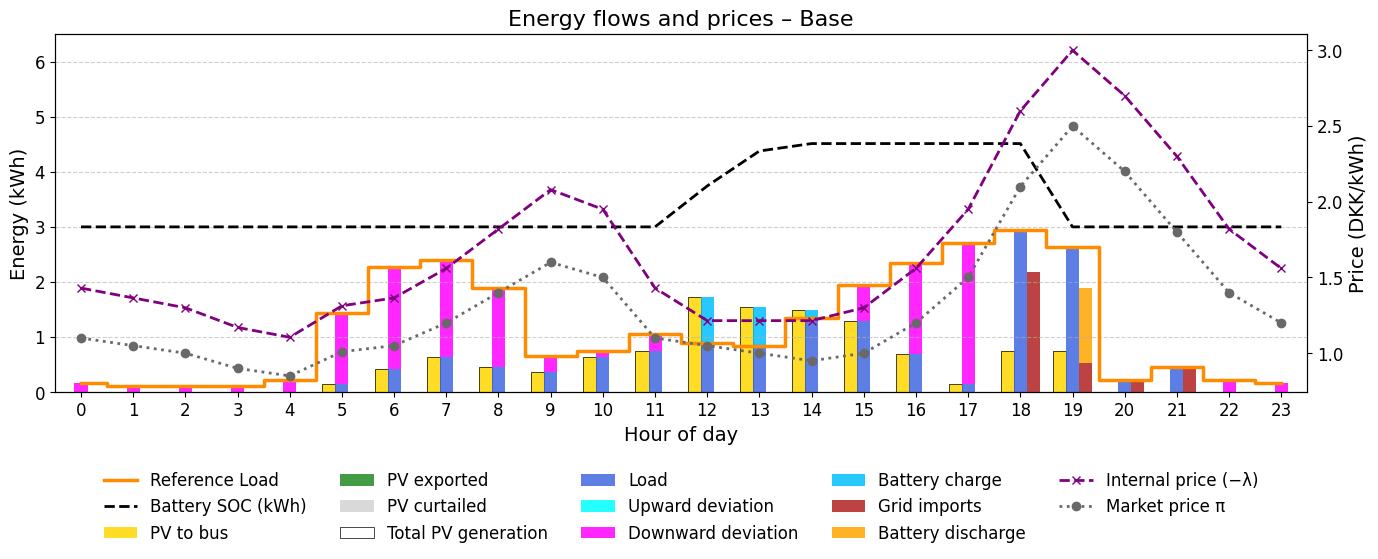

In [6]:
scenario_name = "Base"
sc = scenarios[scenario_name]

input_data = build_input_data_1c(base, sc)
problem = classes.LP_OptimizationProblem(input_data)
problem.run()

df = helpers.results_to_dataframe(problem.results, base["T"])
print(df.head())

duals_lambda = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]

plots.plot_hourly_flows_with_prices_1c(
    df,
    scenario_name,
    duals=duals_lambda,
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"],
    L_ref=base["L_ref"],
    show_battery=True
)

## 6. Multi-Scenario Analysis with Detailed Results

### Individual Scenario Analysis with Battery Operation

Analyze each scenario individually to understand how different pricing structures affect:
- **Battery utilization patterns**: Charging/discharging timing and intensity
- **Load deviation strategies**: How battery availability changes load shifting behavior  
- **PV self-consumption**: Impact of battery on PV utilization patterns
- **Economic performance**: Cost savings and objective function improvements
- **Dual variable insights**: Shadow prices for battery-related constraints

Each scenario shows both the energy flow results and detailed dual variable analysis to provide comprehensive understanding of the optimization decisions.

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0x545a2413
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 144 rows and 73 columns
Presolve time: 0.00s
Presolved: 73 rows, 167 columns, 269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1224500e+01   3.078667e+01   0.000000e+00      0s
      73    2.9841945e+01   0.000000e+00   0.000000e+00      0s

Solved in 73 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.984194500e+01


,lambda,rho,nu,delta,alpha,beta,kappa,omega_up,omega_low
h0,-1.430,-1.430,0.0,1.430,0.0,0.0,-2.7,0.0,0.0
h1,-1.365,-1.365,0.0,1.365,0.0,0.0,-2.7,0.0,0.0
h2,-1.300,-1.300,0.0,1.300,0.0,0.0,-2.7,0.0,0.0
h3,-1.170,-1.260,0.0,1.170,0.0,0.0,-2.7,0.0,0.0
h4,-1.105,-1.325,0.0,1.105,0.0,0.0,-2.7,0.0,0.0
h5,-1.313,-1.313,0.0,1.313,0.0,0.0,-2.7,0.0,0.0
h6,-1.365,-1.365,0.0,1.365,0.0,0.0,-2.7,0.0,0.0
h7,-1.560,-1.560,0.0,1.560,0.0,0.0,-2.7,0.0,0.0
h8,-1.820,-1.820,0.0,1.820,0.0,0.0,-2.7,0.0,0.0
h9,-2.080,-2.080,0.0,2.080,0.0,0.0,-2.7,0.0,0.0


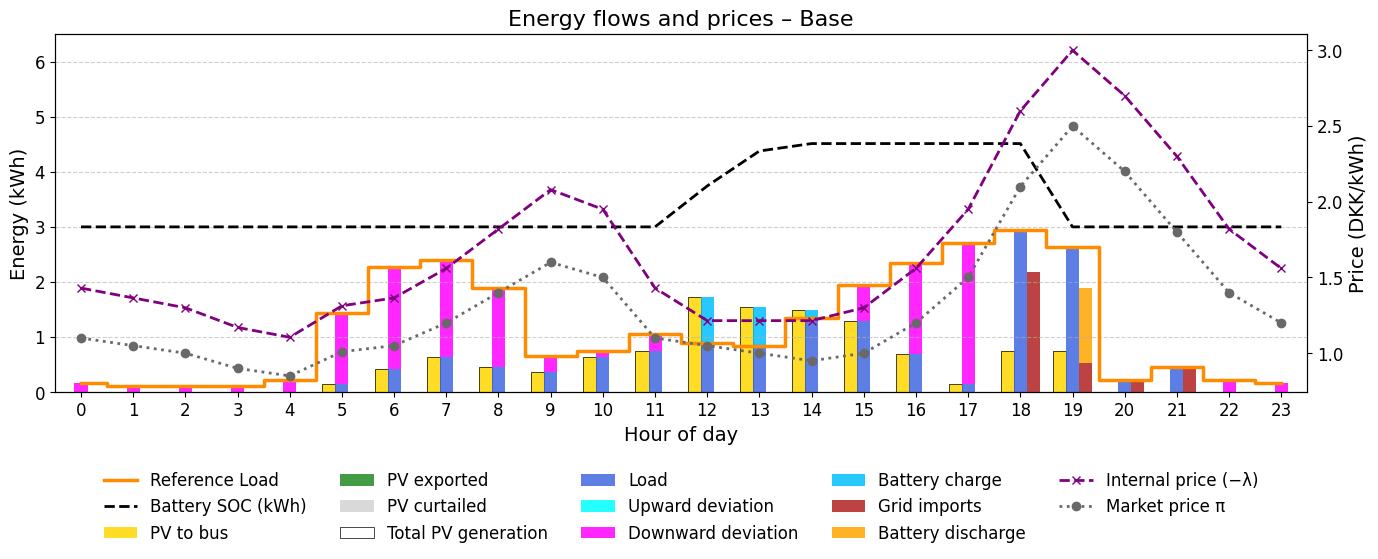

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0xed6cbb04
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [9e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 146 rows and 77 columns
Presolve time: 0.00s
Presolved: 71 rows, 163 columns, 263 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2381175e+01   3.048667e+01   0.000000e+00      0s
      53    2.7497139e+01   0.000000e+00   0.000000e+00      0s

Solved in 53 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.749713875e+01


,lambda,rho,nu,delta,alpha,beta,kappa,omega_up,omega_low
h0,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h1,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h2,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h3,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h4,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h5,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h6,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h7,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h8,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0
h9,-1.7149,-1.7149,0.0,1.7149,0.0,0.0,-1.5434,0.0,0.0


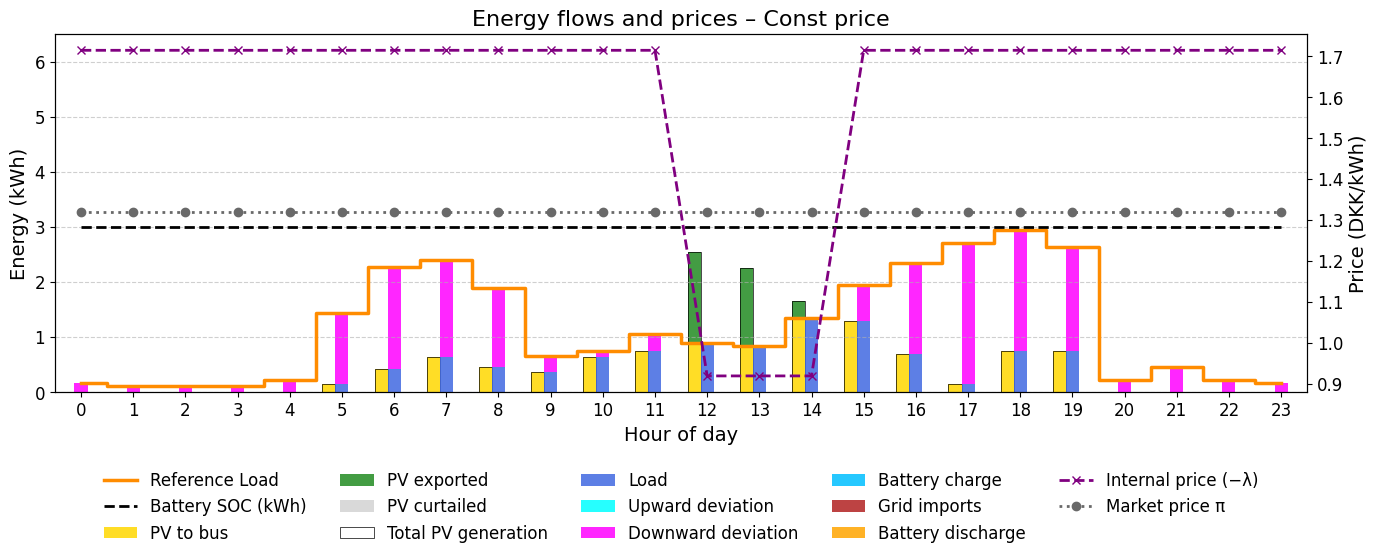

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0xeabbab4f
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [8e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 137 rows and 59 columns
Presolve time: 0.00s
Presolved: 80 rows, 181 columns, 290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6612500e+01   3.271500e+01   0.000000e+00      0s
      54    2.3146594e+01   0.000000e+00   0.000000e+00      0s

Solved in 54 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.314659444e+01


,lambda,rho,nu,delta,alpha,beta,kappa,omega_up,omega_low
h0,-1.10,-1.10,0.0,1.10,0.0,0.0000,-2.2222,0.0,0.0
h1,-1.05,-1.05,0.0,1.05,0.0,0.0000,-2.2222,0.0,0.0
h2,-1.00,-1.00,0.0,1.00,0.0,0.0000,-2.2222,0.0,0.0
h3,-0.90,-1.10,0.0,0.90,0.0,0.0000,-2.2222,0.0,0.0
h4,-0.85,-1.15,0.0,0.85,0.0,-0.1000,-2.2222,0.0,0.0
h5,-1.01,-1.01,0.0,1.01,0.0,0.0000,-2.2222,0.0,0.0
h6,-1.05,-1.05,0.0,1.05,0.0,0.0000,-2.2222,0.0,0.0
h7,-1.20,-1.20,0.0,1.20,0.0,0.0000,-2.2222,0.0,0.0
h8,-1.40,-1.40,0.0,1.40,0.0,0.0000,-2.2222,0.0,0.0
h9,-1.60,-1.60,0.0,1.60,0.0,0.0000,-2.2222,0.0,0.0


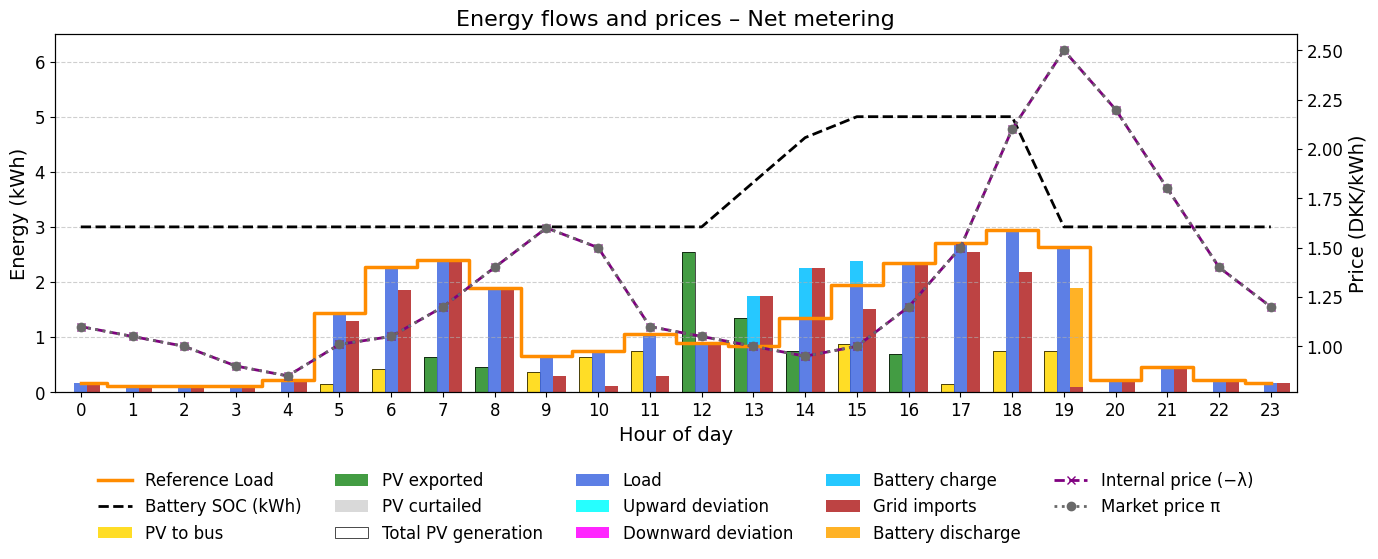

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0xdb6b8f89
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e-02, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 144 rows and 88 columns
Presolve time: 0.00s
Presolved: 73 rows, 152 columns, 254 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.078667e+01   0.000000e+00      0s
      66    2.9841945e+01   0.000000e+00   0.000000e+00      0s

Solved in 66 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.984194500e+01


,lambda,rho,nu,delta,alpha,beta,kappa,omega_up,omega_low
h0,-1.430,-1.430,0.0,1.430,0.0,0.0,-2.7,0.0,0.0
h1,-1.365,-1.365,0.0,1.365,0.0,0.0,-2.7,0.0,0.0
h2,-1.300,-1.300,0.0,1.300,0.0,0.0,-2.7,0.0,0.0
h3,-1.170,-1.260,0.0,1.170,0.0,0.0,-2.7,0.0,0.0
h4,-1.105,-1.325,0.0,1.105,0.0,0.0,-2.7,0.0,0.0
h5,-1.313,-1.313,0.0,1.313,0.0,0.0,-2.7,0.0,0.0
h6,-1.365,-1.365,0.0,1.365,0.0,0.0,-2.7,0.0,0.0
h7,-1.560,-1.560,0.0,1.560,0.0,0.0,-2.7,0.0,0.0
h8,-1.820,-1.820,0.0,1.820,0.0,0.0,-2.7,0.0,0.0
h9,-2.080,-2.080,0.0,2.080,0.0,0.0,-2.7,0.0,0.0


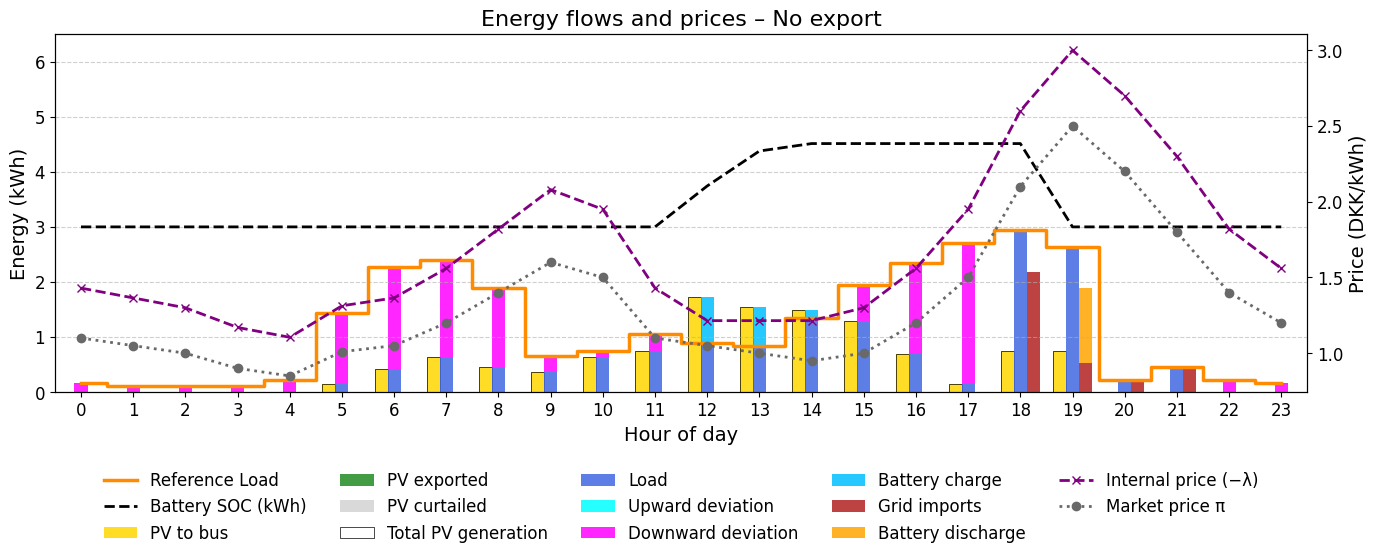

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0x16d55eaa
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [4e-01, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 144 rows and 73 columns
Presolve time: 0.01s
Presolved: 73 rows, 167 columns, 269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4674500e+01   3.078667e+01   0.000000e+00      0s
      72    3.4599445e+01   0.000000e+00   0.000000e+00      0s

Solved in 72 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.459944500e+01


,lambda,rho,nu,delta,alpha,beta,kappa,omega_up,omega_low
h0,-1.430,-1.430,0.0,1.430,0.0,0.00,-3.0333,0.0,0.0000
h1,-1.365,-1.365,0.0,1.365,0.0,0.00,-3.0333,0.0,0.0000
h2,-1.300,-1.430,0.0,1.300,0.0,-0.13,-3.0333,0.0,0.0000
h3,-1.170,-1.560,0.0,1.170,0.0,0.00,-3.0333,0.0,0.0000
h4,-1.105,-1.625,0.0,1.105,0.0,0.00,-3.0333,0.0,0.0000
h5,-1.365,-1.365,0.0,1.313,0.0,0.00,-3.0333,0.0,0.0000
h6,-1.365,-1.365,0.0,1.365,0.0,0.00,-3.0333,0.0,0.0000
h7,-1.560,-1.560,0.0,1.560,0.0,0.00,-3.0333,0.0,0.0000
h8,-1.820,-1.820,0.0,1.820,0.0,0.00,-3.0333,0.0,-1.1967
h9,-2.080,-2.080,0.0,2.080,0.0,0.00,-3.0333,0.0,0.0000


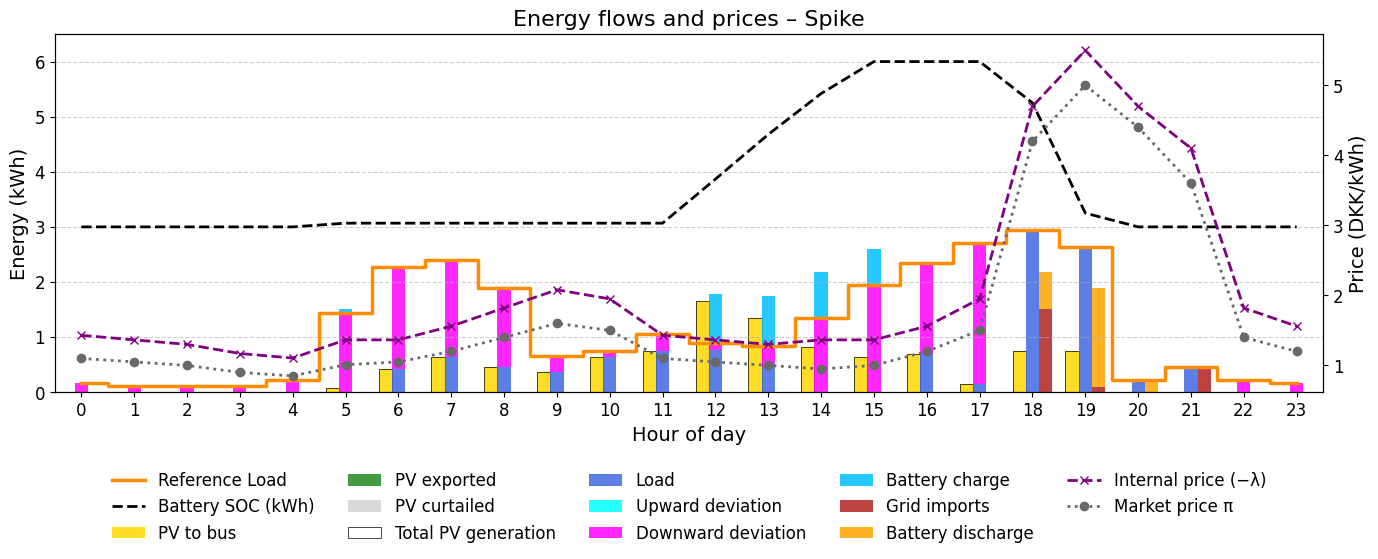

,Objective,Total import,Total export,Total curtailed,Total load,Total upward dev,Total downward dev,Total battery charge,Total battery discharge,Final SOC
Base,29.841945,3.394200,0.00,0.0,14.865000,0.0,13.080000,1.680000,1.3608,3.0
Const price,27.497139,0.000000,3.36,0.0,10.110000,0.0,17.835000,0.000000,0.0000,3.0
Net metering,23.146594,23.539444,6.42,0.0,27.945000,0.0,0.000000,2.222222,1.8000,3.0
No export,29.841945,3.394200,0.00,0.0,14.865000,0.0,13.080000,1.680000,1.3608,3.0
Spike,34.599445,2.055000,0.00,0.0,11.558333,0.0,16.386667,3.333333,2.7000,3.0


In [7]:
scenario_names = ["Base", "Const price", "Net metering", "No export", "Spike"]

dfs = []
duals_list = []
price_list = []
alpha_list = []
beta_list = []
l_ref_list = []
results_summary = {}

for scenario_name in scenario_names:
    sc = scenarios[scenario_name]
    input_data = build_input_data_1c(base, sc)
    problem = classes.LP_OptimizationProblem(input_data)
    problem.run()
    df = helpers.results_to_dataframe(problem.results, base["T"])
    dfs.append(df)
    duals_lambda = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]
    duals_list.append(duals_lambda)
    price_list.append(sc["price"])
    alpha_list.append(sc["price"] + sc["imp"])
    beta_list.append(sc["price"] - sc["exp"])
    l_ref_list.append(base["L_ref"])
    results_summary[scenario_name] = {
        "Objective": problem.results.objective_value,
        "Total import": df["e"].sum(),
        "Total export": df["s"].sum(),
        "Total curtailed": df["c"].sum(),
        "Total load": df["l"].sum(),
        "Total upward dev": df["d+"].sum(),
        "Total downward dev": df["d-"].sum(),
        "Total battery charge": df["b_ch"].sum(),
        "Total battery discharge": df["b_dis"].sum(),
        "Final SOC": df["soc"].iloc[-1]
    }


    duals_display = helpers.collect_duals_by_index(problem, base["T"])
    df_duals_display = helpers.duals_to_dataframe(duals_display)
    display(df_duals_display.T)
    plots.plot_hourly_flows_with_prices_1c(
        df,
        scenario_name,
        duals=duals_lambda,
        price=sc["price"],
        alpha=sc["price"] + sc["imp"],
        beta=sc["price"] - sc["exp"],
        L_ref=base["L_ref"],
        show_battery=True
    )

df_results = pd.DataFrame(results_summary).T
df_results

## 7. Comparative Analysis & Reporting

### Multi-Scenario Results Summary

Compare battery-enabled optimization results across all scenarios to understand:

**Battery Value Proposition:**
- **Economic benefits**: Cost reductions from temporal energy arbitrage
- **Flexibility enhancement**: How battery complements existing flexibility resources
- **Scenario sensitivity**: Which pricing structures most benefit from battery storage
- **Operational patterns**: Optimal battery utilization strategies

**Key Performance Indicators:**
- **Total costs**: Objective function values including energy and discomfort costs
- **Battery utilization**: Total charging/discharging volumes and final SOC
- **Energy flows**: Impact on imports, exports, and PV self-consumption
- **Load patterns**: Changes in deviation behavior with battery availability

**Expected Insights:**
- **Price spike scenarios**: Battery should provide highest value during volatile pricing
- **Net metering**: Perfect price symmetry may reduce battery arbitrage value
- **Constant price**: Battery value limited to PV time-shifting applications
- **No export**: Battery enables better PV utilization through storage
- **Base scenario**: Balanced battery operation for both arbitrage and PV storage

**Dual Variable Analysis:**
- **λₜ (energy balance)**: Internal energy prices reflecting battery arbitrage opportunities
- **κₜ (SOC dynamics)**: Battery energy values showing optimal charge/discharge timing
- **αₜ/βₜ (power limits)**: Binding constraints limiting battery operation
- **ωₜ (capacity limits)**: SOC bounds affecting storage strategies

The comprehensive analysis demonstrates how battery storage transforms the consumer's optimization problem from pure load shifting and PV management to sophisticated multi-resource flexibility coordination.

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0x545a2413
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
Optimize a model with 217 rows, 240 columns and 504 nonzeros
Model fingerprint: 0x545a2413
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 144 rows and 73 columns
Presolve time: 0.01s
Presolved: 73 rows, 167 columns, 269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1224500e+01   3.078667e+01   0.000000e+00      0s
      73    2.9841945e+01   0.000000e+00   0.000000e+00      0s

Solved in 

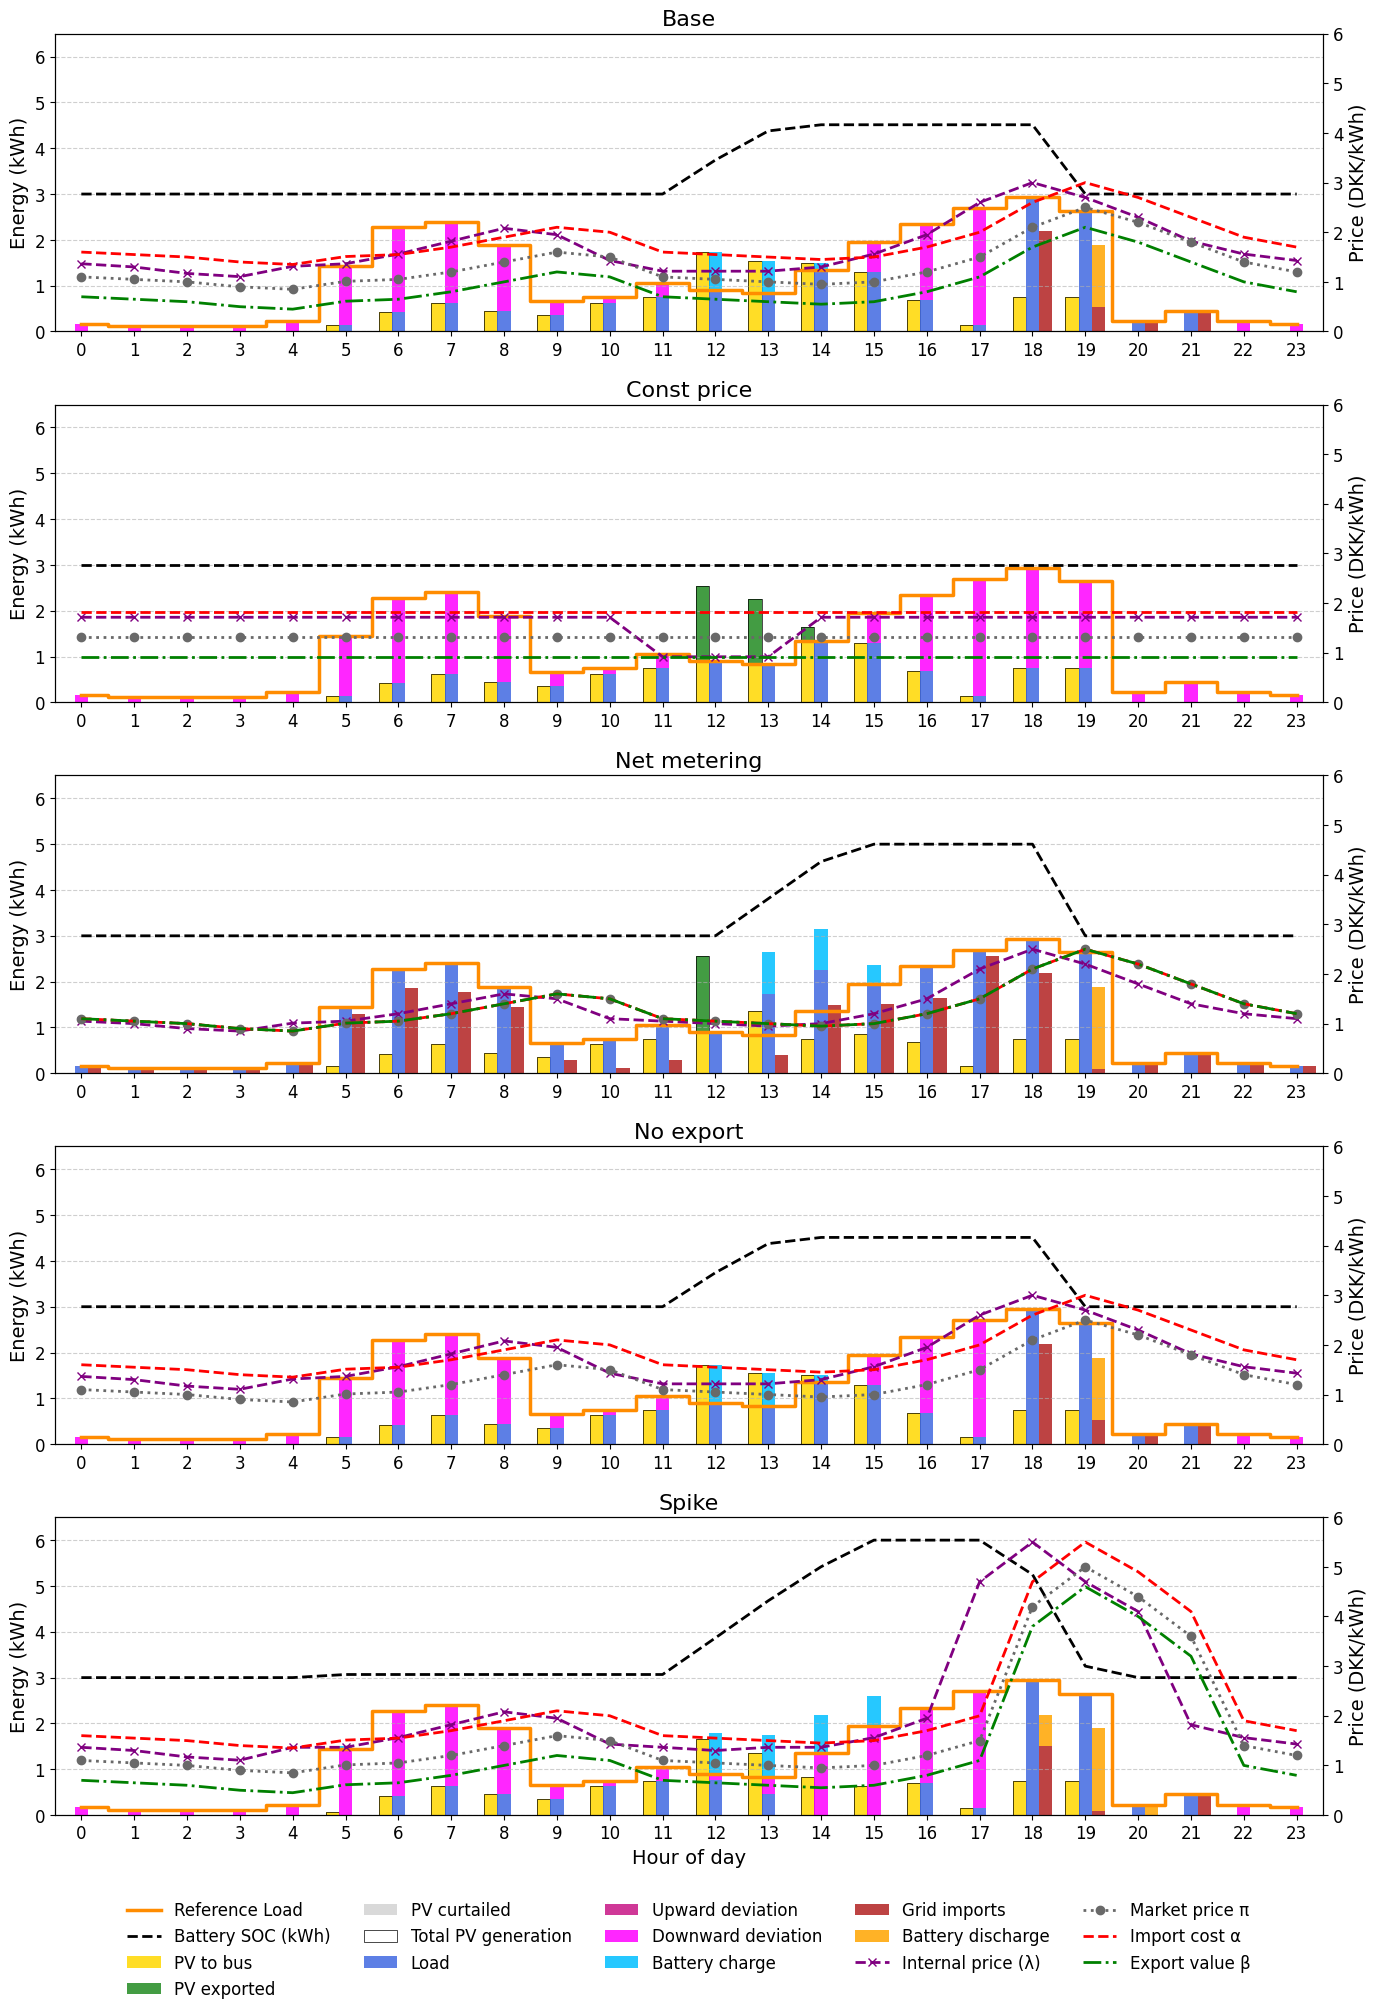

In [10]:
scenario_names = ["Base", "Const price", "Net metering", "No export", "Spike"]

dfs, duals_list, price_list, alpha_list, beta_list, L_refs = [], [], [], [], [], []
results_summary = {}

for scenario_name in scenario_names:
    sc = scenarios[scenario_name]
    input_data = build_input_data_1c(base, sc)  # ⚡ must include battery vars
    problem = classes.LP_OptimizationProblem(input_data)
    problem.run()

    # --- Get results as DataFrame ---
    df = helpers.results_to_dataframe(problem.results, base["T"])

    if scenario_name == "Net metering":
        df = helpers.clean_net_metering_solution(df)

    dfs.append(df)

    # --- Store duals and prices ---
    duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]
    duals_list.append(duals)
    price_list.append(sc["price"])
    alpha_list.append(sc["price"] + sc["imp"])
    beta_list.append(sc["price"] - sc["exp"])
    L_refs.append(base.get("L_ref", None))  # optional reference load

    # --- Summaries ---
    mu = problem.results.duals.get("constr[0]", np.nan)
    lambdas = duals
    results_summary[scenario_name] = {
        "Objective": problem.results.objective_value,
        "Total import": df.get("e", pd.Series(0)).sum(),
        "Total export": df.get("s", pd.Series(0)).sum(),
        "Total curtailed": df.get("c", pd.Series(0)).sum(),
        "Total load": df.get("l", pd.Series(0)).sum(),
        "mu": mu,
        "lambda_mean": np.mean(lambdas),
        "lambda_min": np.min(lambdas),
        "lambda_max": np.max(lambdas),
    }

# --- Export summary table ---
df_results = pd.DataFrame(results_summary).T
print(df_results.to_latex(float_format="%.2f",
                          caption="Primal and dual results with battery by scenario",
                          label="tab:results_battery"))

# --- Plot all scenarios ---
plots.plot_scenarios_subplots_1c(
    dfs, scenario_names, price_list, alpha_list, beta_list, duals_list,
    L_ref_list=L_refs, ylim=(0,6.5)
)